## Generating similarity score SOL listing

**Author:** Yee Sen, Edited by Benjamin 
<br>
**Date:** 20th Jun 2023
<br>
**Context:** We want to find an optimal threshold to determine if a job is similar to that of the job descriptions within the SOL list. Is it possible to have a generalised threshold or do we need to create individual thresholds for each SOL listing?
<br>
**Objective:** Find an optimal threshold that can be used to classify job descriptions as similar or dissimilar to the SOL listings.


### A) Importing packages and reading in the dataset

In [24]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import requests
from ast import literal_eval

In [25]:
df = pd.read_csv('../data/sol.csv')
df = df.replace('\n', '', regex=True)
df['id'] = df['id'].astype(str).str.replace(' ', '')

df = df.reset_index(drop=True)

In [26]:
main_url = "http://localhost:8000/sentence_embeddings?id"

def query_api(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

In [27]:
sol_df = pd.read_csv('../data/SOL_embeddings_sentence_transformers.csv')
sol_df['emb_title'] = sol_df['emb_title'].apply(literal_eval)
sol_df['emb_text'] = sol_df['emb_text'].apply(literal_eval)
sol_df['comb'] = [x + y for x,y in zip(sol_df['emb_title'], sol_df['emb_text'])]

sol_detailed_df = pd.read_excel('../data/SOL Verification checks.xlsx', sheet_name = 1)

In [28]:
def similarity(vec1, vec2):
    return vec1 @ vec2.T/(norm(vec1)*norm(vec2))

In [29]:
from tqdm import tqdm
results=[]

for index, row in tqdm(df.iterrows(), total=len(df)):
    if row['id'] == "-":
        df['combined'][index] = 'NIL'
        df['title'][index] = 'NIL'
        df['text'][index] = 'NIL'
    else:
        try:
            name = row['SOL']
            job_id = row['id']
            res = query_api(f'{main_url}={job_id}')
            concat_r1 = np.array(res['embeddings_title'] + res['embeddings_text']).reshape(1, -1)
            title_r1 = np.array(res['embeddings_title']).reshape(1,-1)
            text_r1 = np.array(res['embeddings_text']).reshape(1,-1)
            result_df = pd.DataFrame({"SOL Occupation":sol_df['SOL Occupation'],
                                      "Combined similarity": list(map(lambda x: similarity(concat_r1, np.array(x)).round(3), sol_df['comb'])),
                                      "Title similarity": list(map(lambda x: similarity(title_r1, np.array(x)).round(3), sol_df['emb_title'])),
                                      "Text similarity": list(map(lambda x: similarity(text_r1, np.array(x)).round(3), sol_df['emb_text']))})

            combined_similarity_value1 = result_df.loc[result_df['SOL Occupation'] == name, 'Combined similarity'].values[0]
            combined_similarity_value2 = result_df.loc[result_df['SOL Occupation'] == name, 'Title similarity'].values[0]
            combined_similarity_value3 = result_df.loc[result_df['SOL Occupation'] == name, 'Text similarity'].values[0]
            df['combined'][index] = combined_similarity_value1[0]
            df['title'][index] = combined_similarity_value2[0]
            df['text'][index] = combined_similarity_value3[0]

        except:
            df['combined'][index] = 'NIL'
            df['title'][index] = 'NIL'
            df['text'][index] = 'NIL'



  0%|                                                                                          | 0/145 [00:00<?, ?it/s]C:\Users\Yee Sen Tan\AppData\Local\Temp\ipykernel_7976\636463013.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined'][index] = combined_similarity_value1[0]
C:\Users\Yee Sen Tan\AppData\Local\Temp\ipykernel_7976\636463013.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'][index] = combined_similarity_value2[0]
C:\Users\Yee Sen Tan\AppData\Local\Temp\ipykernel_7976\636463013.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

In [31]:
df.head(20)

,SOL,id,combined,title,text
0,AI researcher/engineer,MCF-2023-0316898,0.704,0.89,0.519
1,AI researcher/engineer,MCF-2022-0928188,0.741,0.89,0.592
2,AI researcher/engineer,MCF-2023-0443124,0.727,0.89,0.564
3,AI researcher/engineer,MCF-2023-0429654,0.78,0.89,0.671
4,AI researcher/engineer,MCF-2023-0383691,0.721,0.89,0.553
5,Alternative protein food application scientist,MCF-2022-0568735,0.728,0.681,0.775
6,Alternative protein food application scientist,MCF-2022-0397937,0.704,0.67,0.737
7,Alternative protein food application scientist,MCF-2021-0421058,0.74,0.681,0.799
8,Alternative protein food application scientist,MCF-2021-0478993,0.605,0.769,0.44
9,Alternative protein food application scientist,MCF-2021-0186229,0.683,0.781,0.584


### B) Exporting CSV and cleaning it

In [17]:
# Some jobs returned 'NIL', export csv and manually fill in (a few rows only)

In [19]:
df.to_csv('../data/similarities.csv')

In [32]:
df = pd.read_csv('../data/similarities.csv')

In [33]:
df

,Unnamed: 0,SOL,id,combined,title,text
0,0,AI researcher/engineer,MCF-2023-0316898,0.704,0.890,0.519
1,1,AI researcher/engineer,MCF-2022-0928188,0.741,0.890,0.592
2,2,AI researcher/engineer,MCF-2023-0443124,0.727,0.890,0.564
3,3,AI researcher/engineer,MCF-2023-0429654,0.780,0.890,0.671
4,4,AI researcher/engineer,MCF-2023-0383691,0.721,0.890,0.553
...,...,...,...,...,...,...
140,140,Web and mobile applications developer,MCF-2023-0332909,0.641,0.775,0.507
141,141,Web and mobile applications developer,MCF-2023-0223620,0.736,0.793,0.679
142,142,Web and mobile applications developer,MCF-2023-0281532,0.627,0.700,0.555
143,143,Web and mobile applications developer,MCF-2023-0298100,0.572,0.618,0.526


### C) Visualizing similarities to aid threshold selection

In [35]:
del df['Unnamed: 0']
del df['SOL']
del df['id']
df = df.reset_index(drop=True)
df = df.astype(float)
df
df = df.rename(columns={
    'combined': 'combined-SOL Jobs',
    'title': 'title-SOL Jobs',
    'text': 'text-SOL Jobs'
})


In [36]:
df

,combined-SOL Jobs,title-SOL Jobs,text-SOL Jobs
0,0.704,0.890,0.519
1,0.741,0.890,0.592
2,0.727,0.890,0.564
3,0.780,0.890,0.671
4,0.721,0.890,0.553
...,...,...,...
140,0.641,0.775,0.507
141,0.736,0.793,0.679
142,0.627,0.700,0.555
143,0.572,0.618,0.526


#### Note: df2 CSV are jobs that is not on the SOL List

In [38]:
df2 = pd.read_csv('../data/similarity - NON SOL.csv')
# Drop columns other than combined, title, and text
df2 = df2.drop(['Unnamed: 0', 'Searched Title', 'id', 'SOL based on combined', 'SOL based on title', 'SOL based on text'], axis=1)

df2 = df2.reset_index(drop=True)
df2 = df2.astype(float)

df2 = df2.rename(columns={
    'combined': 'combined-Non SOL Jobs',
    'title': 'title-Non SOL Jobs',
    'text': 'text-Non SOL Jobs'
})

In [42]:
merged_df = pd.concat([df, df2], axis=1)

# Reorder the columns
merged_df = merged_df[['combined-SOL Jobs', 'combined-Non SOL Jobs', 'title-SOL Jobs', 'title-Non SOL Jobs', 'text-SOL Jobs', 'text-Non SOL Jobs']]

merged_df.head(3)

,combined-SOL Jobs,combined-Non SOL Jobs,title-SOL Jobs,title-Non SOL Jobs,text-SOL Jobs,text-Non SOL Jobs
0,0.704,0.430,0.89,0.496,0.519,0.363
1,0.741,0.407,0.89,0.435,0.592,0.394
2,0.727,0.358,0.89,0.510,0.564,0.338


In [43]:
df_comb= merged_df[[ 'combined-SOL Jobs', 'combined-Non SOL Jobs']]
df_title= merged_df[[ 'title-SOL Jobs', 'title-Non SOL Jobs']]
df_text= merged_df[['text-SOL Jobs', 'text-Non SOL Jobs']]

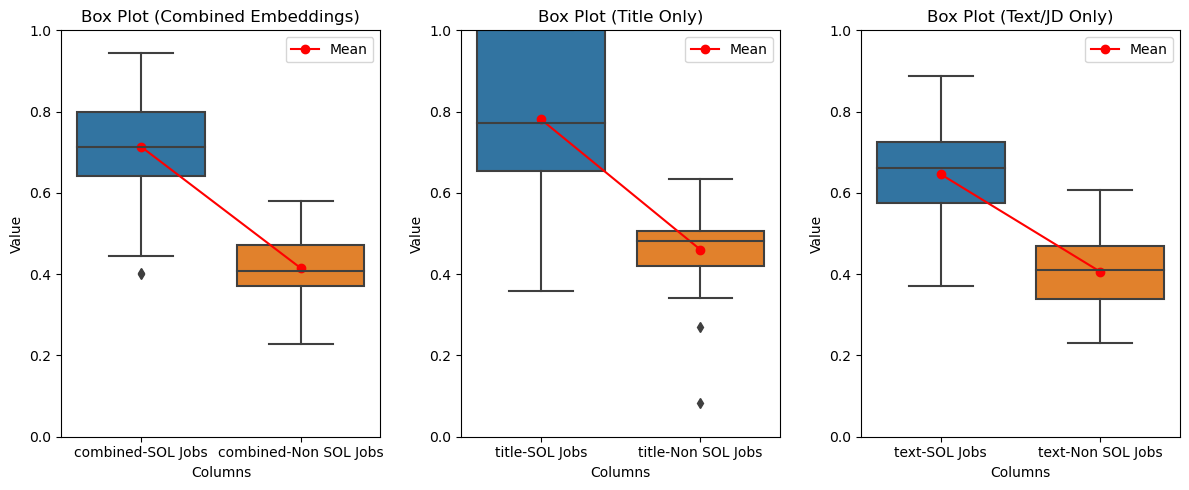

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Box plot with mean of Combined
sns.boxplot(data=df_comb, ax=axes[0])
mean_values = df_comb.mean()  # Calculate mean values
axes[0].plot(range(len(mean_values)), mean_values, marker='o', color='red', label='Mean')  # Add mean values to the plot
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Value')
axes[0].set_title('Box Plot (Combined Embeddings)')
axes[0].legend(loc='upper right')
axes[0].set_ylim(0, 1.0)

# Box plot with mean of Title
sns.boxplot(data=df_title, ax=axes[1])
mean_values = df_title.mean()  # Calculate mean values
axes[1].plot(range(len(mean_values)), mean_values, marker='o', color='red', label='Mean')  # Add mean values to the plot
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Value')
axes[1].set_title('Box Plot (Title Only)')
axes[1].legend(loc='upper right')
axes[1].set_ylim(0, 1.0)

# Box plot with mean of Text
sns.boxplot(data=df_text, ax=axes[2])
mean_values = df_text.mean()  # Calculate mean values
axes[2].plot(range(len(mean_values)), mean_values, marker='o', color='red', label='Mean')  # Add mean values to the plot
axes[2].set_xlabel('Columns')
axes[2].set_ylabel('Value')
axes[2].set_title('Box Plot (Text/JD Only)')
axes[2].legend(loc='upper right')
axes[2].set_ylim(0, 1.0)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [52]:
temp_df = pd.read_csv('../data/similarities.csv')

In [54]:
del temp_df['Unnamed: 0']
del temp_df['id']

In [82]:
# SOL_COMBINED = temp_df.groupby('SOL')['combined'].min()

In [83]:
# SOL_TITLE = temp_df.groupby('SOL')['title'].min()

In [84]:
# SOL_TEXT = temp_df.groupby('SOL')['text'].min()

In [85]:
# SOL_COMBINED

### D) Finding Optimal

In [176]:
df1 = pd.read_csv('../data/similarities.csv')
df2 = pd.read_csv('../data/similarity - non SOL.csv')

In [177]:
df1

,Unnamed: 0,SOL,id,combined,title,text
0,0,AI researcher/engineer,MCF-2023-0316898,0.704,0.890,0.519
1,1,AI researcher/engineer,MCF-2022-0928188,0.741,0.890,0.592
2,2,AI researcher/engineer,MCF-2023-0443124,0.727,0.890,0.564
3,3,AI researcher/engineer,MCF-2023-0429654,0.780,0.890,0.671
4,4,AI researcher/engineer,MCF-2023-0383691,0.721,0.890,0.553
...,...,...,...,...,...,...
140,140,Web and mobile applications developer,MCF-2023-0332909,0.641,0.775,0.507
141,141,Web and mobile applications developer,MCF-2023-0223620,0.736,0.793,0.679
142,142,Web and mobile applications developer,MCF-2023-0281532,0.627,0.700,0.555
143,143,Web and mobile applications developer,MCF-2023-0298100,0.572,0.618,0.526


In [178]:
df1 = df1[['combined','title','text']]
df2 = df2[['combined','title','text']]

In [179]:
df1['label']=1 #label 1 = SOL
df2['label']=0 #label 0 = Non SOL

C:\Users\Yee Sen Tan\AppData\Local\Temp\ipykernel_7976\1666903435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['label']=1 #label 1 = SOL


In [180]:
combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df['predict'] = ""

In [181]:
combined_df

,combined,title,text,label,predict
0,0.704,0.890,0.519,1,
1,0.741,0.890,0.592,1,
2,0.727,0.890,0.564,1,
3,0.780,0.890,0.671,1,
4,0.721,0.890,0.553,1,
...,...,...,...,...,...
182,0.429,0.407,0.490,0,
183,0.388,0.495,0.327,0,
184,0.429,0.418,0.440,0,
185,0.345,0.341,0.368,0,


In [183]:
from tqdm import tqdm
pd.options.mode.chained_assignment = None
for index, row in tqdm(combined_df.iterrows(), total=len(combined_df)):
    if (row['title'] > 0.6) or (row['combined'] > 0.6) or (row['text'] > 0.6):
        combined_df['predict'][index]=1
    else:
        combined_df['predict'][index]=0

results = combined_df[['label','predict']]
results['label'] = pd.to_numeric(results['label'], errors='coerce')
results['predict'] = pd.to_numeric(results['predict'], errors='coerce')

100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 3419.56it/s]


In [184]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

labels = results['label']
predictions = results['predict']

label_names = ['non sol', 'sol']

cm = confusion_matrix(labels, predictions)
confusion_df = pd.DataFrame(cm, index=['Actual ' + label for label in label_names], 
                            columns=['Predicted ' + label for label in label_names])

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_df)


print("")
print("")

# Calculate precision
precision = precision_score(labels, predictions)
print("Precision:", round(precision,3))

# Calculate recall
recall = recall_score(labels, predictions)
print("Recall:", round(recall,3))

# Calculate F1 score
f1 = f1_score(labels, predictions)
print("F1 Score:", round(f1,3))

Confusion Matrix:
                Predicted non sol  Predicted sol
Actual non sol                 39              3
Actual sol                      5            140


Precision: 0.979
Recall: 0.966
F1 Score: 0.972


#### Try different thresholds that maximizes each score

In [185]:
#vales from 0.4 to 0.95
threshold_values = np.arange(0.4, 0.95, 0.05)
max_f1_score = 0.0
max_p_score = 0.0
max_r_score = 0.0
best_thresholdf = 0.0
best_thresholdp = 0.0
best_thresholdr = 0.0
# Disable the warning
pd.options.mode.chained_assignment = None

for threshold in threshold_values:
    for index, row in tqdm(combined_df.iterrows(), total=len(combined_df)):
        if (row['title'] > threshold) or (row['combined'] > threshold) or (row['text'] > threshold):
            combined_df.loc[index, 'predict'] = 1
        else:
            combined_df.loc[index, 'predict'] = 0
    
    results = combined_df[['label', 'predict']]
    results['label'] = pd.to_numeric(results['label'], errors='coerce')
    results['predict'] = pd.to_numeric(results['predict'], errors='coerce')

    labels = results['label']
    predictions = results['predict']

    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    # Update max score and best threshold
    if f1 > max_f1_score:
        max_f1_score = f1
        best_thresholdf = threshold

    if precision > max_p_score:
        max_p_score = precision
        best_thresholdp = threshold       

    if f1 > max_r_score:
        max_r_score = recall
        best_thresholdr = threshold

pd.options.mode.chained_assignment = 'warn'

print("Maximum F1 Score:", round(max_f1_score, 3))
print("Best Threshold:", best_thresholdf)
print("")
print("Maximum Recall:", round(max_p_score, 3))
print("Best Threshold:", best_thresholdp)
print("")
print("Maximum Precision:", round(max_r_score, 3))
print("Best Threshold:", best_thresholdr)

100%|██████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 4415.40it/s]

Maximum F1 Score: 0.972
Best Threshold: 0.6

Maximum Recall: 1.0
Best Threshold: 0.6499999999999999

Maximum Precision: 1.0
Best Threshold: 0.4
